In [1]:
# Librerias

import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import nltk
from nltk.corpus import stopwords
import re
import time
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import FunctionTransformer
from nltk import RegexpTokenizer
from sklearn.decomposition import TruncatedSVD 

from sklearn.base import BaseEstimator, TransformerMixin
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [2]:
# Ver el ejemplo de entrega

submission_example = pd.read_csv('data/sample_submission.csv')
submission_example.tail(5)

,ID,label
5110,5111,0
5111,5112,0
5112,5113,0
5113,5114,0
5114,5115,0


In [3]:
# Importar los datos

training_raw = pd.read_csv('data/train.csv')
print(f'Total de datos = {training_raw.size}')
training_raw.tail(5)

Total de datos = 181452


,text,book,label
60479,"Reflecting on what had been thus told me, I fe...",David_Copperfield,0
60480,"He so near her, and in misery.\r\nShe was\r\nr...",Mansfield_Park,2
60481,‘We are going to Mr. Wickfield’s\r\nfirst.’\r\...,David_Copperfield,0
60482,The elder Mr. Weller drove a coach for twelve ...,The_Pickwick_Papers,0
60483,"Had he put his gold somewhere\r\nelse, by a su...",Silas_Marner,1


In [4]:
X = training_raw['text']  # Solo el texto
L = training_raw['book']  # Nombre del libro
y = training_raw['label']  # Etiquetas

# Dividir en train y test
X_train, X_test, y_train, y_test, L_train, L_test = train_test_split(X, y, L, test_size = 0.2)

# Ingenieria de caracteristicas
X_train = L_train.fillna("") + " " + X_train.fillna("")

# Aplicar oversampling
ros = RandomOverSampler(sampling_strategy='all')    
X_train, y_train = ros.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train))

# Convertir correctamente a listas después de oversampling
X_train = X_train.iloc[:, 0].tolist()
y_train = y_train.iloc[:, 0].tolist()

# Verificar ejemplos
print("Ejemplo de X_train:\n", X_train[0])  # Con book concatenado
print("\nEjemplo de X_test:\n", X_test.iloc[0])  # Sin book concatenado

Ejemplo de X_train:
 The_Pickwick_Papers Mr. Snodgrass acknowledged the compliment.
'I always like to hear a good argument,' continued the bagman, 'a sharp
one, like this: it's very improving; but this little argument about
women brought to my mind a story I have heard an old uncle of mine tell,
the recollection of which, just now, made me say there were rummer
things than women to be met with, sometimes.'

Ejemplo de X_test:
 “Will you go along with me, Oliver?” said Mr. Bumble, in a majestic
voice.


In [5]:
class TextClassifier(BaseEstimator, TransformerMixin):
    """
    A text processing class for text classification. This transformer handles tokenization,
    text cleaning, and transforms text data into a TF-IDF representation, then classifies
    it using Naive Bayes.
    """
    def __init__(self, token_cue=r'\w+', language='english'):
        self.language = language
        self.token_cue = token_cue
        self.tokenizer = RegexpTokenizer(self.token_cue)
        self.scaler = MaxAbsScaler()
        self.vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents = 'ascii', lowercase = False, max_df=0.8, ngram_range=(1, 2))
        self.classifier = MultinomialNB()  

    def fit(self, text, y):
        """ Ajusta el vectorizador y entrena el clasificador Naive Bayes """
        processed_text = self.preprocess_text(text)
        processed_text = [' '.join(tokens) for tokens in processed_text]  # Convertir listas a strings
        
        X_vectors = self.vectorizer.fit_transform(processed_text)  # Vectorización de texto
        X_vectors = self.scaler.fit_transform(X_vectors)  # Normalizar con el scaler
        self.classifier.fit(X_vectors, y)  # Entrenar el clasificador
        return self

    def transform(self, text):
        """ Transforma el texto a su representación TF-IDF """
        processed_text = self.preprocess_text(text)
        processed_text = [' '.join(tokens) for tokens in processed_text]  # Convertir listas a strings
        
        X_vectors = self.vectorizer.transform(processed_text)
        return self.scaler.transform(X_vectors)

    def predict(self, X):
        """ Predice etiquetas de clase para los textos de entrada """
        X_vectors = self.transform(X)
        return self.classifier.predict(X_vectors)

    def predict_proba(self, X):
        """ Retorna probabilidades de cada clase para los textos de entrada """
        X_vectors = self.transform(X)
        return self.classifier.predict_proba(X_vectors)

    def tokenize(self, text):
        """ Tokeniza el texto """
        return text.apply(lambda x: self.tokenizer.tokenize(x))

    def preprocess_text(self, text):
        """ Limpia y tokeniza el texto, retornando listas de palabras """
        if isinstance(text, pd.Series):  # Si es un Pandas Series
            text = text.tolist()
        
        processed_text = []
        for sentence in text:
            #sentence = sentence.lower()  # Convertir a minúsculas
            #sentence = re.sub(r'[^a-zA-Z0-9\s]', '', sentence)  # Eliminar puntuación y caracteres especiales
            tokens = self.tokenizer.tokenize(sentence)  # Tokenización
            processed_text.append(tokens)  # Guardar lista de tokens

        return processed_text

tiempo de procesamiento: 0.43m
              precision    recall  f1-score   support

           0       0.94      0.86      0.89      5153
           1       0.86      0.89      0.88      3242
           2       0.75      0.93      0.83      1953
           3       0.82      0.78      0.80       936
           4       0.94      0.87      0.90       813

    accuracy                           0.87     12097
   macro avg       0.86      0.86      0.86     12097
weighted avg       0.88      0.87      0.87     12097


 >> Resultados en Validacion: <<
  - F1 Score: 0.8605


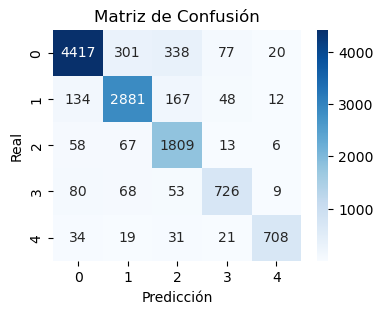

In [6]:
start = time.time()
model = TextClassifier()#token_cue = r'(\w+\s+\w+)')
model.fit(X_train, y_train)
end = time.time()
print(f'tiempo de procesamiento: {((end - start)/60):.2f}m')
# Evaluación en conjunto de Evaluacion
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n >> Resultados en Validacion: <<")
# print(f"  - Accuracy: {accuracy:.4f}")
# print(f"  - Precision: {precision:.4f}")
# print(f"  - Recall: {recall:.4f}")
print(f"  - F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [7]:
#confusion_matrix(y_test, y_pred)

In [8]:
submission_raw = pd.read_csv('data/test.csv')
print(f'Total de datos = {submission_raw.size}')
submission_raw.tail(5)

Total de datos = 10230


,ID,text
5110,5111,"I’ll to England.\r\nTo Ireland, I.\r\nOur sepa..."
5111,5112,250: _to_] F1.\r\n_by_ F2 F3 F4.\r\n_Keep_] _S...
5112,5113,"Here come two noble beasts in, a man and a lio..."
5113,5114,Therefore I have entreated him along\r\nWith u...
5114,5115,"Who calls on Hamlet?\r\nO, here they come.\r\n..."


In [9]:
X_submission = submission_raw['text']
y_pred_submission = model.predict(X_submission)

idx = submission_raw['ID']
df = pd.DataFrame({'ID': idx, 'label': y_pred_submission})
print(df.tail(5))
df.to_csv('submission.csv', index=False)

        ID  label
5110  5111      4
5111  5112      4
5112  5113      4
5113  5114      0
5114  5115      4
